Perintah ini digunakan untuk menyalin file konfigurasi kaggle.json ke direktori

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


Dataset akan diunduh ke direktori dalam bentuk format ZIP.

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 97% 336M/346M [00:04<00:00, 90.3MB/s]
100% 346M/346M [00:04<00:00, 82.7MB/s]


Memverifikasi isi folder setelah ekstraksi, sehingga dapat melihat semua file dataset yang telah diekstrak.

In [3]:
!unzip intel-image-classification.zip -d intel-image-classification
!ls intel-image-classification

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: intel-image-classification/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel-image-classification/seg_train/seg_train/m

#IMPORT DATA

Mengimpor berbagai pustaka dan modul yang diperlukan untuk analisis data, pemrosesan gambar, visualisasi, dan pelatihan model

In [19]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

import tensorflow_hub as hub

#LOAD DATASET

Untuk mengorganisir dan mengeksplorasi struktur dataset gambar, serta memberikan gambaran umum tentang jumlah gambar yang tersedia dalam masing-masing class untuk pelatihan dan pengujian.

In [6]:
base_dir='/content/intel-image-classification' #yang menyimpan jalur ke direktori utama dari dataset klasifikasi gambar Intel.

print("The directories present are",os.listdir(base_dir)) #Menggunakan fungsi os.listdir() untuk menampilkan daftar direktori dan file yang ada di dalam base_dir. Ini berguna untuk memverifikasi struktur folder dataset.

train_dir='/content/intel-image-classification/seg_train/seg_train'
test_dir='/content/intel-image-classification/seg_test/seg_test'
print('\n') #Menyimpan jalur ke direktori pelatihan yang berisi gambar.

building_train='/content/intel-image-classification/seg_train/seg_train/buildings'
forest_train='/content/intel-image-classification/seg_train/seg_train/forest'
glacier_train='/content/intel-image-classification/seg_train/seg_train/glacier'
mountain_train='/content/intel-image-classification/seg_train/seg_train/mountain'
sea_train='/content/intel-image-classification/seg_train/seg_train/sea'
street_train='/content/intel-image-classification/seg_train/seg_train/street'

building_test='/content/intel-image-classification/seg_test/seg_test/buildings'
forest_test='/content/intel-image-classification/seg_test/seg_test/forest'
glacier_test='/content/intel-image-classification/seg_test/seg_test/glacier'
mountain_test='/content/intel-image-classification/seg_test/seg_test/mountain'
sea_test='/content/intel-image-classification/seg_test/seg_test/sea'
street_test='/content/intel-image-classification/seg_test/seg_test/street'

print("train data total:", len(os.listdir(train_dir)))
print("test data total:", len(os.listdir(train_dir)))

print("Building train images:", len(os.listdir(building_train)))
print("Forest train images:", len(os.listdir(forest_train)))
print("Glacier train images:", len(os.listdir(glacier_train)))
print("Mountain train images:", len(os.listdir(mountain_train)))
print("Sea train images:", len(os.listdir(sea_train)))
print("Street train images:", len(os.listdir(street_train)))
print('\n')
print("Building test images:", len(os.listdir(building_test)))
print("Forest test images:", len(os.listdir(forest_test)))
print("Glacier test images:", len(os.listdir(glacier_test)))
print("Mountain test images:", len(os.listdir(mountain_test)))
print("Sea test images:", len(os.listdir(sea_test)))
print("Street test images:", len(os.listdir(street_test)))

The directories present are ['seg_train', 'seg_pred', 'seg_test']


train data total: 6
test data total: 6
Building train images: 2191
Forest train images: 2271
Glacier train images: 2404
Mountain train images: 2512
Sea train images: 2274
Street train images: 2382


Building test images: 437
Forest test images: 474
Glacier test images: 553
Mountain test images: 525
Sea test images: 510
Street test images: 501


Untuk memuat sejumlah gambar dari direktori tertentu, mengubah ukurannya, dan menyimpannya dalam list untuk digunakan lebih lanjut, seperti untuk analisis atau pelatihan model.

In [7]:
def load_images(directory, num_files=5): #Fungsi ini didefinisikan dengan nama load_images, yang menerima dua argumen:
    images = [] #Membuat list kosong bernama images untuk menyimpan gambar yang akan dimuat
    file_list = os.listdir(directory)[:num_files]  # Jumlah file yang akan dimuat. Secara default, ini diatur ke 5

    for filename in tqdm(file_list, desc=f"Loading images from {directory}"): #Untuk menampilkan progress bar, memberikan informasi visual tentang kemajuan pemuatan gambar.
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        img = img.resize((150, 150))  # Resize image to 150 x 150
        images.append(img)

    return images

Memuat gambar dari berbagai class (buildings, forest, glacier, mountain, sea, street) dari direktori pelatihan masing-masing.

In [8]:
buildings_img = load_images(building_train)
forest_img = load_images(forest_train)
glacier_img = load_images(glacier_train)
mountain_img = load_images(mountain_train)
sea_img = load_images(sea_train)
street_img = load_images(street_train)

Loading images from /content/intel-image-classification/seg_train/seg_train/buildings: 100%|██████████| 5/5 [00:00<00:00, 85.94it/s]
Loading images from /content/intel-image-classification/seg_train/seg_train/forest: 100%|██████████| 5/5 [00:00<00:00, 1233.18it/s]
Loading images from /content/intel-image-classification/seg_train/seg_train/glacier: 100%|██████████| 5/5 [00:00<00:00, 1269.08it/s]
Loading images from /content/intel-image-classification/seg_train/seg_train/mountain: 100%|██████████| 5/5 [00:00<00:00, 1096.66it/s]
Loading images from /content/intel-image-classification/seg_train/seg_train/sea: 100%|██████████| 5/5 [00:00<00:00, 1005.97it/s]
Loading images from /content/intel-image-classification/seg_train/seg_train/street: 100%|██████████| 5/5 [00:00<00:00, 1099.42it/s]


untuk membuat visualisasi dari gambar-gambar pelatihan yang diambil dari berbagai kategori (buildings, forest, glacier, mountain, sea, street). Gambar-gambar ini ditampilkan dalam format grid

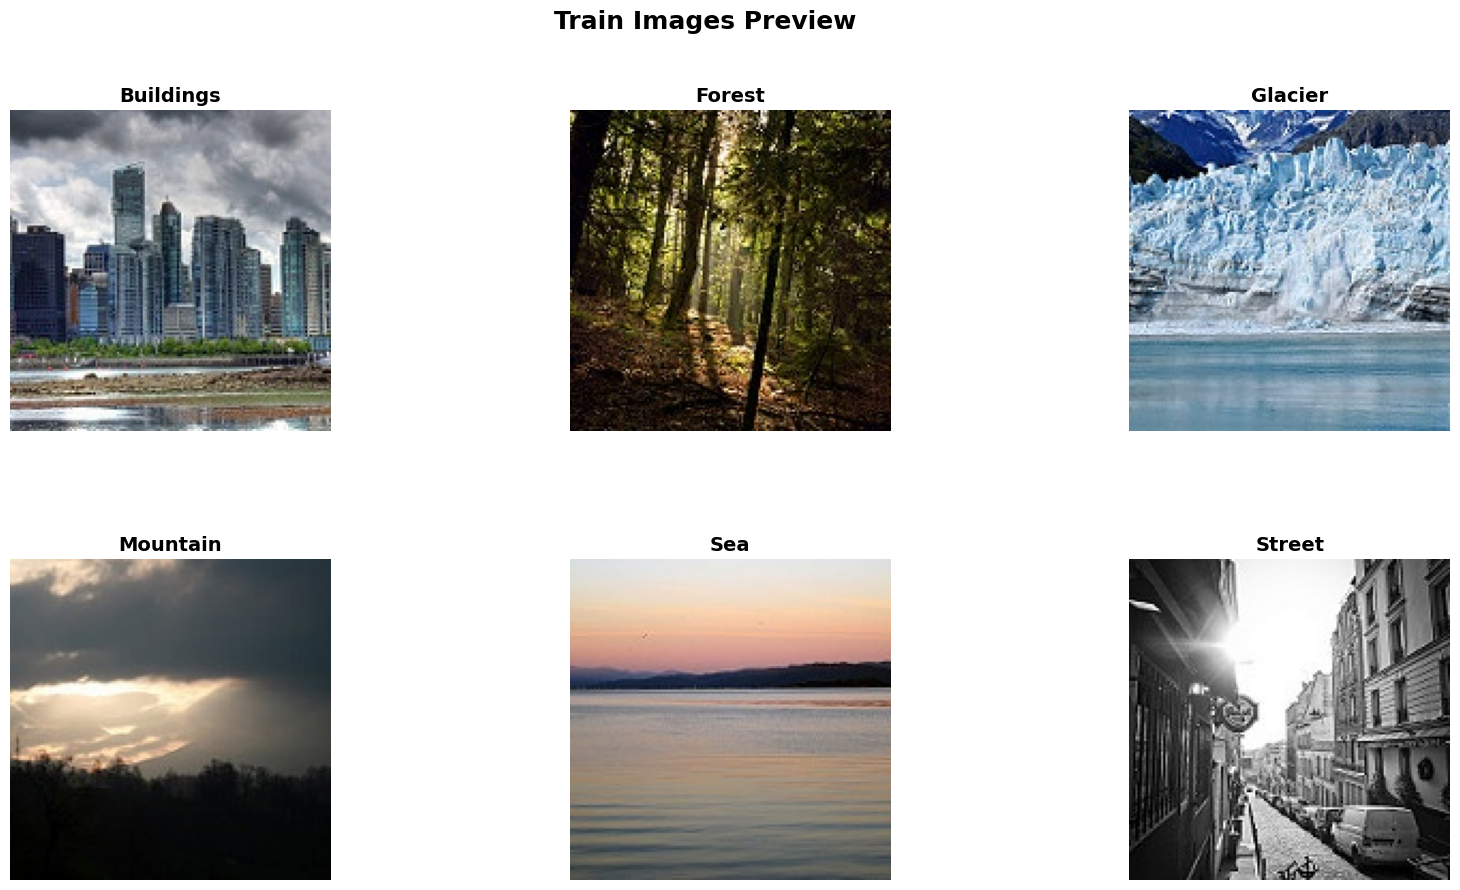

In [9]:
plt.rcParams["figure.figsize"] = (20, 10)
fig, axs = plt.subplots(2, 3, gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

categories = ['Buildings', 'Forest', 'Glacier', 'Mountain', 'Sea', 'Street']
images = [buildings_img, forest_img, glacier_img, mountain_img, sea_img, street_img]

for i, (category, category_imgs) in enumerate(zip(categories[:6], images[:6])):
    axs[i//3, i%3].imshow(category_imgs[0])
    axs[i//3, i%3].axis('off')
    axs[i//3, i%3].set_title(category, fontsize=14, fontweight='bold')

plt.suptitle('Train Images Preview', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#PREPROCESSING

Untuk mengidentifikasi dan mengambil nama class dari subdirektori dalam direktori

In [10]:
train_data_directory = pathlib.Path('/content/intel-image-classification/seg_train/seg_train')
class_names = sorted([item.name for item in train_data_directory.glob('*')][:6])
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Untuk memuat dan memproses data gambar untuk pelatihan dan pengujian, dengan melakukan normalisasi dan mengubah ukuran gambar

In [11]:
train_data_gen=ImageDataGenerator(rescale = 1/255.) #untuk melakukan augmentasi data secara real-time dan juga untuk normalisasi data gambar
test_data_gen=ImageDataGenerator(rescale=1/255.) #untuk melakukan augmentasi data secara real-time dan juga untuk normalisasi data gambar

train_data = train_data_gen.flow_from_directory(train_dir,
                                          target_size = (224, 224),
                                          batch_size = 32,
                                          class_mode = 'categorical')
val_data = test_data_gen.flow_from_directory(test_dir,
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        class_mode = 'categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Untuk mengambil satu batch gambar dan label dari generator data

In [12]:
images, labels = next(train_data)
len(images), len(labels), images[0].shape

(32, 32, (224, 224, 3))

Untuk mengambil satu batch data dari generator validasi dan memeriksa jumlah gambar serta label dalam batch tersebut, serta melihat dimensi dari gambar pertama

In [13]:
images1, labels1 = next(val_data)
len(images1), len(labels1), images1[0].shape

(32, 32, (224, 224, 3))

In [14]:
train_data, val_data

(<keras.src.legacy.preprocessing.image.DirectoryIterator at 0x7af6c3d78a30>,
 <keras.src.legacy.preprocessing.image.DirectoryIterator at 0x7af74d2b18d0>)

#MODEL BUILDING

Untuk mengklasifikasikan gambar ke dalam 6 kategori Class

In [15]:
model = tf.keras.Sequential([
            tf.keras.Input(shape = images[0].shape),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dense(6, activation = 'softmax'),
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Untuk memberikan gambaran yang jelas tentang layer, dimensi data, dan parameter yang terlibat dalam model

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      25,690,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,710,406 (98.08 MB)

 Trainable params: 25,710,406 (98.08 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [20]:
classifier=model.fit(train_data,
                         validation_data=val_data,
                         batch_size=32,
                         steps_per_epoch=100,
                         validation_steps=50,
                         verbose=1,
                         epochs=10,
                         callbacks=[reduce_lr])

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.6480 - loss: 0.9308 - val_accuracy: 0.6069 - val_loss: 0.9869 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.7039 - loss: 0.7936 - val_accuracy: 0.6914 - val_loss: 0.8127 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.7641 - loss: 0.6689 - val_accuracy: 0.7400 - val_loss: 0.7528 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 365s 4s/step - accuracy: 0.7959 - loss: 0.5763 - val_accuracy: 0.7586 - val_loss: 0.6787 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8108 - loss: 0.5341 - val_accuracy: 0.7394 - val_loss: 0.7567 - learning_rate: 0.0010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 398s 4s/step - accuracy: 0.8380 - loss: 0.5055 - val_accuracy: 0.7421 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.8621 - loss: 0.

#MODEL EVALUATION

In [21]:
model.evaluate(val_data)

94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 900ms/step - accuracy: 0.7272 - loss: 0.8231


[0.8145260214805603, 0.7369999885559082]

Untuk memvisualisasikan kinerja model selama pelatihan dengan menggambarkan akurasi dan loss dari waktu ke waktu

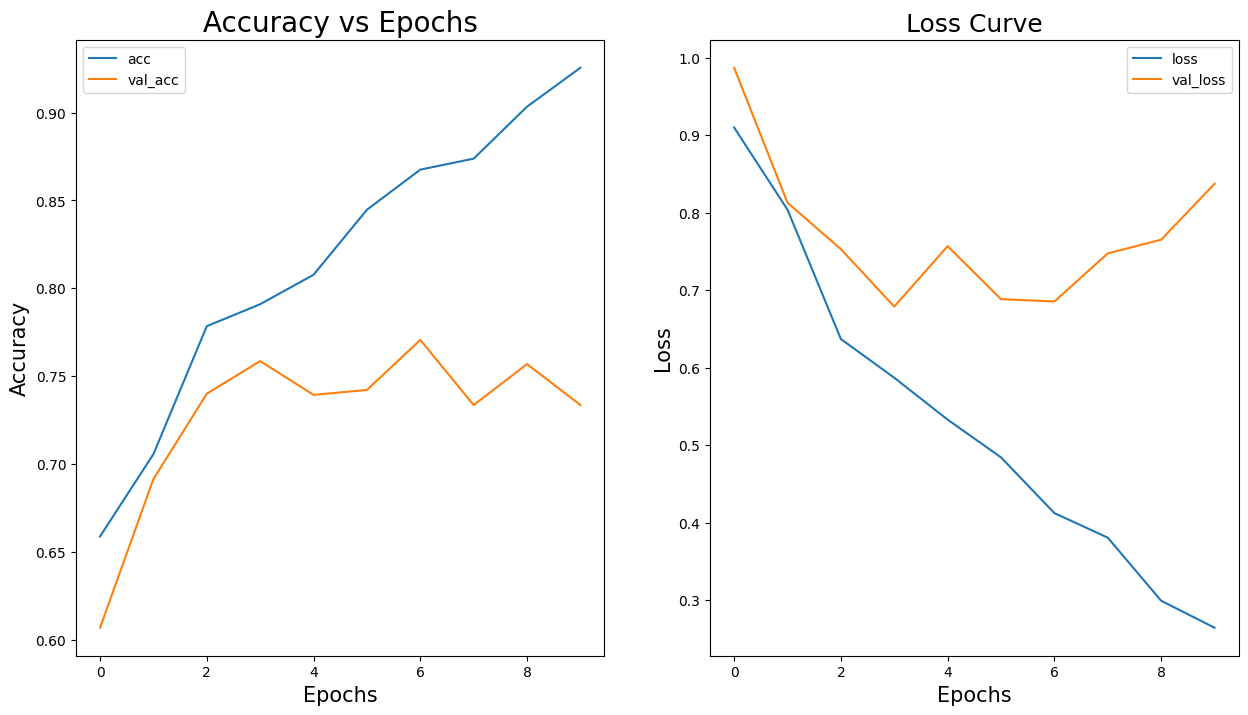

In [22]:
def model_performance_graphs():

    fig, axes = plt.subplots(1, 2, figsize = (15, 8))

    axes[0].plot(classifier.epoch, classifier.history['accuracy'], label = 'acc')
    axes[0].plot(classifier.epoch, classifier.history['val_accuracy'], label = 'val_acc')
    axes[0].set_title('Accuracy vs Epochs', fontsize = 20)
    axes[0].set_xlabel('Epochs', fontsize = 15)
    axes[0].set_ylabel('Accuracy', fontsize = 15)
    axes[0].legend()

    axes[1].plot(classifier.epoch, classifier.history['loss'], label = 'loss')
    axes[1].plot(classifier.epoch, classifier.history['val_loss'], label="val_loss")
    axes[1].set_title("Loss Curve",fontsize=18)
    axes[1].set_xlabel("Epochs",fontsize=15)
    axes[1].set_ylabel("Loss",fontsize=15)
    axes[1].legend()

    plt.show()

model_performance_graphs()

Menyimpan model

In [56]:
model.save('intel.h5')
print("Model Saved")

Model Saved


Untuk memuat gambar, mengubahnya menjadi array, menyesuaikan dimensi, dan menormalisasi nilai piksel, sehingga gambar siap digunakan

In [57]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0

    return img_preprocessed

Memuat model Keras yang telah disimpan dalam file h5

In [58]:
loaded_model = tf.keras.models.load_model('/content/intel.h5')

Melakukan prediksi menggunakan model yang telah dilatih untuk menampilkan gambar

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


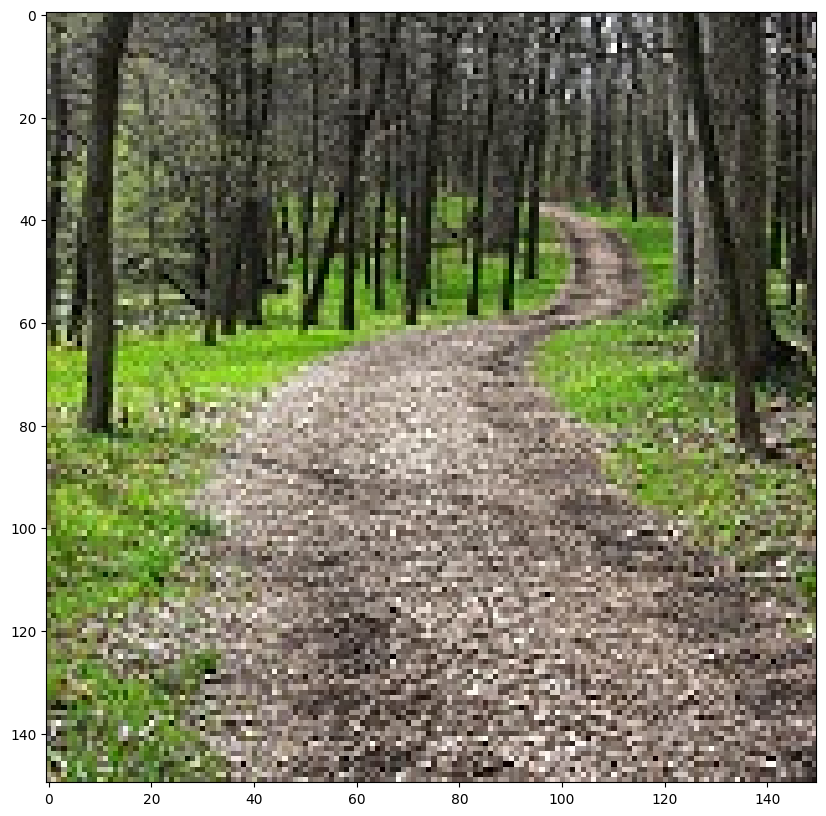

Predicted class: forest


In [59]:
from skimage.io import imread
img_path = "/content/intel-image-classification/seg_train/seg_train/forest/10604.jpg"
img = preprocess_images(img_path)
prediction = loaded_model.predict(img)
img = imread(img_path)
plt.imshow(img)
plt.show()

predicted_class_index = np.argmax(prediction)

class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)